COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One.

SelfScalableTanh from  Self-scalable Tanh (Stan): Faster Convergence and Better Generalization in Physics-informed Neural Networks
https://arxiv.org/abs/2204.1258
Motivation: my gut said its a good idea. Impact: little bit faster convergence even in gpt9
harmonic loss from  Harmonic Loss Trains Interpretable AI Models
https://arxiv.org/abs/2502.01628note that I do the math in log space to avoid explosions
motivation: interpretable model. Impact: slows down convergence somewhat

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat

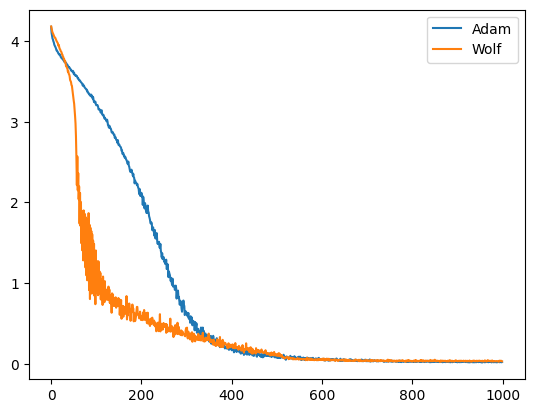
m 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [2]:
# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class SelfScalableTanh(nn.Module):
    def __init__(self, init_scale=0.1, max_scale=0.12):
        super().__init__()
        # Learned scale parameter
        self.scale = nn.Parameter(torch.tensor(init_scale, dtype=torch.float32))

    def forward(self, x):
        # "Scaled Tanh"
        return torch.tanh(x) + self.scale * torch.tanh(x)


# ---------------------------------------------------
# Differentiable XOR
# ---------------------------------------------------
class DifferentiableXORLayer(nn.Module):
    """
    Splits the incoming embedding in half, and does a
    sigmoid-based XOR-like transformation.
    """
    def __init__(self, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even for XOR."
        self.embed_dim = embed_dim
        self.proj = nn.Linear(embed_dim // 2, embed_dim)

    def forward(self, x):
        d = self.embed_dim // 2
        x1, x2 = x[..., :d], x[..., d:]
        a = torch.sigmoid(x1)
        b = torch.sigmoid(x2)
        # approximate XOR = a + b - 2ab
        xor_out = 0.5 * (a + b - 2 * a * b)  # scaled by 0.5
        out = self.proj(xor_out)
        return out


# ---------------------------------------------------
# Harmonic Distance => Probability
# ---------------------------------------------------
def harmonic_unembedding(hidden_states, unembedding, eps=1e-8):
    """
    hidden_states: (B, seq_len, D)
    unembedding:   (D, vocab_size)  learnable parameter
    returns: p of shape (B, seq_len, vocab_size)

    You had done something like:
      distances = sqrt(sum((x - w)^2))
      log_inv_dn = - H * log(distances)
      log_p = log_inv_dn - logsumexp(...)
      p = exp(log_p)
    Where H might be int(sqrt(D)).
    """
    B, S, D = hidden_states.shape
    vocab_size = unembedding.shape[1]

    # Expand hidden => (B, S, 1, D)
    x_exp = hidden_states.unsqueeze(2)
    # Expand unembedding => (1,1,vocab_size,D)
    w_exp = unembedding.t().unsqueeze(0).unsqueeze(0)  # (1,1,V,D)
    # L2 distance
    distances = torch.sqrt(torch.sum((x_exp - w_exp)**2, dim=-1) + eps)
    harmonic_exponent = int(math.sqrt(D))

    log_inv_dn = -harmonic_exponent * torch.log(distances + eps)
    log_sum = torch.logsumexp(log_inv_dn, dim=-1, keepdim=True)
    log_p = log_inv_dn - log_sum
    p = torch.exp(log_p)
    return p


In [26]:
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss


In [15]:
class TapeHead(nn.Module):
    """
    A single head that attends over chunked embeddings of size `chunk_size`.
    """
    def __init__(self, embed_dim, chunk_size=2, num_heads=1, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.chunk_size = chunk_size
        self.num_heads = num_heads

        # Project c * D => D to build a chunk embedding
        self.chunk_proj = nn.Linear(chunk_size * embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)
        
    def forward(self, token_emb):
        """
        token_emb: (B, S, D)
        Returns (B, S, D)
        """
        B, S, D = token_emb.shape
        c = self.chunk_size  # e.g. 2, 4, ...
    
        # 1) Move channel/feature dim (D) before the sequence dim (S).
        #    So x_3d is (B, D, S).
        x_3d = token_emb.permute(0, 2, 1)
    
        # 2) Pad the sequence dimension on the RIGHT with (c - 1) zeros.
        #    That matches your original "end" padding if i + c > S.
        #    F.pad takes (left_pad, right_pad) on the last dimension
        #    so we do (0, c - 1).
        x_3d_padded = F.pad(x_3d, (0, c - 1))  # => (B, D, S + c - 1)
    
        # 3) Unfold with kernel_size=(c, 1), stride=(1, 1), no extra padding=...
        #    This "slides" a c-sized window along the (S + c - 1) dimension.
        #    We'll end up with exactly S windows.
        #    x_3d_padded.unsqueeze(-1) => shape (B, D, S+c-1, 1).
        unfolded = F.unfold(
            x_3d_padded.unsqueeze(-1),
            kernel_size=(c, 1),
            stride=(1, 1),
            padding=(0, 0),
        )
        # `unfolded` => (B, D*c, S)
    
        # 4) Transpose so that we have (B, S, D*c).
        unfolded = unfolded.transpose(1, 2)  # (B, S, D*c)
    
        # 5) Project down to (B, S, D).  Each "window" becomes one chunk embedding.
        chunk_tensor = self.chunk_proj(unfolded)  # => (B, S, D)
    
        # 6) Standard self-attention on (B, S, D).
        out, _ = self.attn(chunk_tensor, chunk_tensor, chunk_tensor)
        out = self.ln(chunk_tensor + out)
        return out



class MultiScaleTapeAttention(nn.Module):
    """
    Combines multiple TapeHeads of different chunk sizes (including c=1 for token-level).
    """
    def __init__(self, embed_dim, chunk_sizes=(1,2,4), num_heads=2, dropout=0.0):
        super().__init__()
        self.heads = nn.ModuleList([
            TapeHead(embed_dim, c, num_heads=num_heads, dropout=dropout)
            for c in chunk_sizes
        ])
        # We'll fuse the outputs from each head
        total_dim = len(chunk_sizes) * embed_dim
        self.fuse = nn.Linear(total_dim, embed_dim)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (B, S, D)
        out_heads = []
        for head in self.heads:
            out_heads.append(head(x))
        # cat in feature dim => shape (B, S, total_dim)
        cat_out = torch.cat(out_heads, dim=-1)
        fused = self.fuse(cat_out)
        fused = self.ln(fused)
        return fused


In [8]:
class MultiScaleXORTransformerBlock(nn.Module):
    """
    A single block that:
      - Applies multi-scale "Tape" self-attention
      - Then an MLP with SelfScalableTanh
      - Then a DifferentiableXOR gating
      - Then LN + residual
    """
    def __init__(self, embed_dim, chunk_sizes=(1,2,4), num_heads=2, dropout=0.1, res_scale=1.0):
        super().__init__()
        # Multi-scale attention
        self.attn = MultiScaleTapeAttention(
            embed_dim, chunk_sizes=chunk_sizes, num_heads=num_heads, dropout=dropout
        )
        self.ln1 = nn.LayerNorm(embed_dim)

        # MLP
        self.activation = SelfScalableTanh()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            self.activation,
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        # XOR gating
        self.diff_xor = DifferentiableXORLayer(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.res_scale = res_scale

    def forward(self, x):
        # x shape: (B, S, D)
        attn_out = self.attn(x)
        # Residual + LN
        x = self.ln1(x + self.res_scale * attn_out)

        # MLP
        mlp_out = self.mlp(x)
        # XOR gating
        xor_features = self.diff_xor(mlp_out)
        mlp_out = mlp_out + xor_features

        # second residual + LN
        x = self.ln2(x + self.res_scale * mlp_out)
        return x


In [9]:
class MultiScaleTapeModel(nn.Module):
    """
    End-to-end model:
      - token + positional embeddings
      - N "MultiScaleXORTransformerBlock" layers
      - final harmonic unembedding to produce p(logits)
    """
    def __init__(self,
                 vocab_size,
                 seq_len=128,
                 embed_dim=128,
                 num_layers=4,
                 chunk_sizes=(1,2,4),
                 num_heads=2,
                 dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

        # stack of blocks
        self.blocks = nn.ModuleList([
            MultiScaleXORTransformerBlock(
                embed_dim=embed_dim,
                chunk_sizes=chunk_sizes,
                num_heads=num_heads,
                dropout=dropout
            ) for _ in range(num_layers)
        ])
        # final unembedding for harmonic
                # Separate unembedding matrices per head
        self.unembeddings = nn.ParameterList([
            nn.Parameter(torch.randn(embed_dim, vocab_size))
            for _ in range(num_heads)
        ])
        for unembedding in self.unembeddings:
            nn.init.kaiming_uniform_(unembedding, a=math.sqrt(5))

    def forward(self, x):
        B, S = x.shape
        assert S <= self.seq_len, "Input seq too long for pos_emb"

        # Token + position embeddings
        tok_emb = self.token_emb(x)          # (B, S, D)
        pos_slice = self.pos_emb[:, :S, :]   # (1, S, D)
        h = tok_emb + pos_slice              # (B, S, D)

        # Pass through blocks
        for block in self.blocks:
            h = block(h)

        # Collect outputs from harmonic unembedding per head
        p_all = []
        for unembedding in self.unembeddings:
            p_all.append(harmonic_unembedding(h, unembedding))  # (B, S, V)

        # Aggregate head outputs: mean over heads
        p = torch.stack(p_all, dim=0).mean(dim=0)  # (B, S, V)

        return p

In [ ]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiScaleTapeModel(
    vocab_size=vocab_size,  # example
    seq_len=256,
    embed_dim=128,
    num_layers=8,
    chunk_sizes=(1,2,4,6),
    num_heads=2,
    dropout=0.0
).to(device)

optimizer = Wolf(model.parameters(), lr=6e-4)

scaler = GradScaler()

# For standard loss, we use cross-entropy; for harmonic loss we compute negative log probability manually.

num_epochs = 100
batch_size = 16
seq_len = 256 #from karapathy


wolflosses = []
for epoch in range(num_epochs):

    model.train()

    total_loss = 0.0
    for step in range(10000):  # Adjust the number of steps as needed.
        x_batch, y_batch = get_batch(batch_size, seq_len)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        with autocast():
            p = model(x_batch)
            loss = -torch.log(torch.gather(p, -1, y_batch.unsqueeze(-1)) + 1e-8).squeeze(-1).mean()

        main_loss = loss.detach()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += main_loss
        wolflosses.append(main_loss.cpu())
        if step % 250 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {main_loss:.4f}")

    print(f"Epoch {epoch+1} Average Loss: {total_loss/100:.4f}")

# ====================================================
# Evaluation: Text Generation
# ====================================================

    # Decay rate (tune this to control how fast the bonus decays)
model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


Epoch 1, Step 0, Loss: 4.1714


In [33]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1406152